# 📘 Predicting Rent in Greater Boston

This notebook walks through an end‑to‑end ML workflow to **predict monthly rent** from a scraped real‑estate dataset.

**You’ll learn:**
- how to get structured data from rental websites using Apify
- how to load and inspect tabular data
- basic cleaning and feature engineering
- creating train/test splits and simple baselines
- training a regression model and evaluating it with **MAE** and **R²**

## 1) Setup
Install and import the required packages.

In [120]:
# Install required packages
%pip install pandas scikit-learn matplotlib joblib scikit-optimize apify-client python-dotenv

  Using cached python_dotenv-1.1.1-py3-none-any.whl.metadata (24 kB)
Using cached python_dotenv-1.1.1-py3-none-any.whl (20 kB)

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [60]:
# Import all the libraries we'll need for this tutorial
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Machine learning imports
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

print("✅ All packages installed and libraries imported successfully!")

✅ All packages installed and libraries imported successfully!


## 2) Data Loading

We're working with real estate data scraped from rental listings in the Greater Boston region (Boston, Cambridge and Somerville). This data was collected from Zillow using an [Apify Actor](https://apify.com) available on the Apify Store, the [Zillow Search Scraper](https://apify.com/maxcopell/zillow-scraper).

**What we expect to find:**
- Property details (bedrooms, bathrooms, area)
- Location information (addresses, coordinates)
- Rental prices (our target variable)

Let's start by loading this data and taking our first look at what we're working with.

In [ ]:
# Load existing data from the data folder
data_path = Path("./data/boston-rental-properties.json")
assert data_path.exists(), f"Data not found at {data_path}"

with open(data_path) as f:
    data = json.load(f)
    
print(f"🏠 Successfully loaded {len(data):,} rental listings!")

🏠 Successfully loaded 10,493 rental listings!


For convenience, this notebook already includes a scraped dataset. However, if you’d like to gather your own data for cities you care about, you can tweak the code below to run the Zillow Search Scraper with your own inputs.

In [ ]:
# ‼️ Skip this cell if you decide to go with the existing dataset.
"""Option 2: Run Apify's Zillow Search Scraper to get fresh data"""
from apify_client import ApifyClient
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Read API token and create client
api_token = os.getenv("APIFY_API_TOKEN")

client = ApifyClient(api_token)

run_input = {
    "searchUrls": [
        '''Replace the URL below with your own Zillow search URL '''
        # {
        #     "url": "https://www.zillow.com/chelsea-ma/rentals/?searchQueryState=...",
        #     "method": "GET"
        # }
    ]
}

run = client.actor("maxcopell/zillow-scraper").call(run_input=run_input)

if isinstance(run, dict) and "defaultDatasetId" in run:
    items = list(client.dataset(run["defaultDatasetId"]).iterate_items())
else:
    items = []

# Save for local use
os.makedirs("./data", exist_ok=True)
with open("./data/zillow_rentals.json", "w") as f:
    json.dump(items, f)
data = items

print(f"🏠 Successfully loaded {len(data):,} rental listings!")

[apify.zillow-scraper runId:Q1NkOmCxW65g5TOvP] -> Status: RUNNING, Message: 
[apify.zillow-scraper runId:Q1NkOmCxW65g5TOvP] -> 2025-08-14T04:59:43.265Z ACTOR: Pulling Docker image of build nUXCkTjfVKuNTcQHB from registry.
[apify.zillow-scraper runId:Q1NkOmCxW65g5TOvP] -> 2025-08-14T04:59:43.276Z ACTOR: Creating Docker container.
[apify.zillow-scraper runId:Q1NkOmCxW65g5TOvP] -> 2025-08-14T04:59:43.455Z ACTOR: Starting Docker container.
[apify.zillow-scraper runId:Q1NkOmCxW65g5TOvP] -> 2025-08-14T04:59:47.475Z INFO  System info {"apifyVersion":"3.2.6","apifyClientVersion":"2.10.0","crawleeVersion":"3.12.2","osType":"Linux","nodeVersion":"v20.19.4"}
[apify.zillow-scraper runId:Q1NkOmCxW65g5TOvP] -> Status: RUNNING, Message: Starting the crawler.
[apify.zillow-scraper runId:Q1NkOmCxW65g5TOvP] -> 2025-08-14T04:59:48.156Z INFO  HttpCrawler: Starting the crawler.
[apify.zillow-scraper runId:Q1NkOmCxW65g5TOvP] -> 2025-08-14T04:59:49.796Z INFO  HttpCrawler: Results page 1 for search #0: Scrape

🏠 Successfully loaded 110 rental listings!


## 3) Data exploration

Before we start building our model, we need to understand the data. Think of this as getting to know the ingredients before cooking a meal. 👨‍🍳

**Why this matters:**
- Understanding data structure helps us choose the right features
- Spotting data quality issues early saves time later
- Getting familiar with the data helps us make better modeling decisions

Let's examine a couple of sample records to understand what information we have available:

In [ ]:
# Print the first two listings in the dataset
data[:2]

[{'zpid': '2080797632',
  'palsId': '100066001_e72ee77d0d4c9b71ec1ae0270f68aeaf1ebc46654472d9a05210839295f3b971',
  'id': '2080797632',
  'rawHomeStatusCd': 'ForRent',
  'marketingStatusSimplifiedCd': 'For Rent',
  'providerListingId': 'f5pkkx663gp8',
  'imgSrc': 'https://photos.zillowstatic.com/fp/b9375f7ae073aadcf53fb522ed7c22e6-p_e.jpg',
  'hasImage': True,
  'detailUrl': 'https://www.zillow.com/apartments/cambridge-ma/magazine-street-apartments/CjkpRS/',
  'statusType': 'FOR_RENT',
  'statusText': 'Apartment for rent',
  'countryCurrency': '$',
  'price': '$6,825/mo',
  'unformattedPrice': 6825,
  'address': 'Magazine Street Apartments, 22 Magazine St APT 3, Cambridge, MA 02139',
  'addressStreet': '22 Magazine St APT 3',
  'addressCity': 'Cambridge',
  'addressState': 'MA',
  'addressZipcode': '02139',
  'isUndisclosedAddress': False,
  'beds': 4,
  'baths': 2,
  'area': 1360,
  'latLong': {'latitude': 42.36374, 'longitude': -71.10565},
  'isZillowOwned': False,
  'variableData': 

## 4) Creating our working dataset

The Apify Zillow Scraper gave us a well-structured, detailed dataset to work with, saving us a ton of time right from the start. But raw data alone isn’t ready to be fed into a model just yet. We still need to pull out only the information that’s actually useful for predicting rent prices. Sticking with our kitchen analogy, this step is like picking the right ingredients from a fully stocked pantry. 🥘

**Our feature selection strategy:**
- **Property characteristics**: beds, baths, area (square footage)
- **Location data**: latitude, longitude (extracted from nested latLong field)
- **Target variable**: unformattedPrice (what we want to predict)
- **Context**: address, city, zipcode (for reference, though we won't use these in modeling)

Let's extract these fields and create a clean pandas DataFrame:

In [72]:
# First, let's see all available columns in our data
df_full = pd.DataFrame(data)
print(f"📋 All available columns ({len(df_full.columns)} total):")
print(list(df_full.columns))

# Now extract only the columns we need for rent prediction
print(f"\n🎯 Selecting relevant columns for our model...")
df_work = df_full[['address', 'addressCity', 'addressZipcode', 'beds', 'baths', 'area', 'unformattedPrice']].copy()

# Extract latitude and longitude from the nested latLong field
print(f"📍 Extracting location coordinates...")
latitude = df_full['latLong'].apply(lambda x: x.get('latitude') if isinstance(x, dict) else None)
longitude = df_full['latLong'].apply(lambda x: x.get('longitude') if isinstance(x, dict) else None)

# Add coordinates to our filtered dataframe
df_work['latitude'] = latitude
df_work['longitude'] = longitude

print(f"✅ Created working dataset with {len(df_work)} listings and {len(df_work.columns)} columns")
print(f"\n📊 Our working dataset preview:")
df_work.head()

📋 All available columns (67 total):
['zpid', 'palsId', 'id', 'rawHomeStatusCd', 'marketingStatusSimplifiedCd', 'providerListingId', 'imgSrc', 'hasImage', 'detailUrl', 'statusType', 'statusText', 'countryCurrency', 'price', 'unformattedPrice', 'address', 'addressStreet', 'addressCity', 'addressState', 'addressZipcode', 'isUndisclosedAddress', 'beds', 'baths', 'area', 'latLong', 'isZillowOwned', 'variableData', 'listCardRecommendation', 'hdpData', 'isSaved', 'isUserClaimingOwner', 'isUserConfirmedClaim', 'pgapt', 'sgapt', 'shouldShowZestimateAsPrice', 'has3DModel', 'hasVideo', 'isHomeRec', 'hasAdditionalAttributions', 'isFeaturedListing', 'isShowcaseListing', 'availabilityDate', 'list', 'relaxed', 'carouselPhotosComposable', 'marketingTreatments', 'rooms', 'isPaidBuilderNewConstruction', 'factsAndFeatures', 'foundOnSearchPage', 'foundFromSearchUrl', 'zoomQuadrantSequence', 'units', 'lotId', 'badgeInfo', 'buildingName', 'isBuilding', 'canSaveBuilding', 'availabilityCount', 'isInstantTourE

,address,addressCity,addressZipcode,beds,baths,area,unformattedPrice,latitude,longitude
0,"Magazine Street Apartments, 22 Magazine St APT...",Cambridge,02139,4.0,2.0,1360.0,6825.0,42.363740,-71.10565
1,"375 Harvard St, Cambridge, MA",Cambridge,02138,NaN,NaN,NaN,NaN,42.372055,-71.11215
2,"434 Massachusetts Ave., 434 Massachusetts Ave ...",Cambridge,02139,4.0,2.0,1438.0,6850.0,42.363483,-71.10080
3,"Chauncy Court Apartments, 18-26 Chauncy St #26...",Cambridge,02138,2.0,1.0,880.0,3995.0,42.379986,-71.11993
4,"100 Memorial Dr, Cambridge, MA",Cambridge,02142,NaN,NaN,NaN,NaN,42.360176,-71.08577


## 5) Data cleaning - making our data model-ready

You might’ve noticed some pesky "NaN" values when we visualized the dataset earlier. Turns out, real-world data can be pretty messy! And just like you wouldn’t start cooking without washing your veggies (at least, I hope you wouldn’t), you shouldn’t train a model without giving your data a good clean first.

**Why cleaning matters:**
- **Missing values** can crash our model or give weird predictions
- **Outliers** (like a 50-bedroom apartment) can throw off our model's learning
- **Impossible values** (negative square footage) indicate data errors

**Our cleaning strategy:**
1. **Remove missing values**: Drop listings missing critical information
2. **Remove outliers**: Use statistical methods to identify and remove extreme values
3. **Validate data**: Ensure all values make sense (positive areas, reasonable prices)

Let's start by checking for missing data:

In [73]:
# First, let's see how much missing data we have
missing_data = df_work.isnull().sum()
for column, missing_count in missing_data.items():
    if missing_count > 0:
        percentage = (missing_count / len(df_work)) * 100
        print(f"{column}: {missing_count} missing ({percentage:.1f}%)")

print(f"\n📊 Total listings before cleaning: {len(df_work):,}")

# Remove listings with missing critical data
listings_before_drop = len(df_work)
df_filtered = df_work.dropna()
listings_after_drop = len(df_filtered)

removed_count = listings_before_drop - listings_after_drop
removal_percentage = (removed_count / listings_before_drop) * 100

print(f"🗑️  Removed {removed_count:,} listings due to missing data ({removal_percentage:.1f}%)")
print(f"✅ Clean dataset now has {listings_after_drop:,} listings")

beds: 2726 missing (26.0%)
baths: 2726 missing (26.0%)
area: 5448 missing (51.9%)
unformattedPrice: 2726 missing (26.0%)
latitude: 1440 missing (13.7%)
longitude: 1440 missing (13.7%)

📊 Total listings before cleaning: 10,493
🗑️  Removed 5,780 listings due to missing data (55.1%)
✅ Clean dataset now has 4,713 listings


### 5.1) Outlier Detection and Removal

**What are outliers?** Data points that are extremely different from the typical values. For example:
- A 20-bedroom apartment (might be a data entry error)
- A $50,000/month studio (probably a typo)
- A 10,000 square foot "apartment" (might be a commercial space)

**Our approach:** We'll use the IQR (Interquartile Range) method, which is robust and easy to understand:
- Calculate Q1 (25th percentile) and Q3 (75th percentile) 
- Anything below Q1 - 1.5×IQR or above Q3 + 1.5×IQR is considered an outlier

In [116]:
# Remove outliers using the IQR method
def remove_outliers_iqr(df, columns):
    """
    Remove outliers using the IQR (Interquartile Range) method.
    """
    
    df_clean = df.copy()
    
    print(f"\n🔧 Applying outlier removal:")
    
    for column in columns:
        # Calculate quartiles and IQR
        Q1 = df_clean[column].quantile(0.25)
        Q3 = df_clean[column].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define outlier bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Remove outliers
        before_count = len(df_clean)
        df_clean = df_clean[(df_clean[column] >= lower_bound) & (df_clean[column] <= upper_bound)]
        after_count = len(df_clean)
        
        removed = before_count - after_count
        print(f"   • {column}: removed {removed} outliers (bounds: {lower_bound:.0f} - {upper_bound:.0f})")
    
    # Additional business logic filter
    before_area_filter = len(df_clean)
    df_clean = df_clean[df_clean['area'] < 9000]  # Remove unreasonably large areas
    area_removed = before_area_filter - len(df_clean)
    if area_removed > 0:
        print(f"   • Additional filter: removed {area_removed} listings with area > 9000 sq ft")
    
    return df_clean

# Apply outlier removal
numeric_cols = ['beds', 'baths', 'area', 'unformattedPrice']
df_clean = remove_outliers_iqr(df_filtered, numeric_cols)

# Summary of cleaning results
initial_count = len(df_filtered)
final_count = len(df_clean)
total_removed = initial_count - final_count
removal_rate = (total_removed / initial_count) * 100

print(f"\n📊 CLEANING SUMMARY:")
print(f"   • Started with: {initial_count:,} listings")
print(f"   • Removed: {total_removed:,} outliers ({removal_rate:.1f}%)")
print(f"   • Final dataset: {final_count:,} clean listings")
print(f"   • Data retention rate: {(final_count/initial_count)*100:.1f}%")


🔧 Applying outlier removal:
   • beds: removed 523 outliers (bounds: 0 - 4)
   • baths: removed 43 outliers (bounds: -0 - 4)
   • area: removed 376 outliers (bounds: 90 - 2106)
   • unformattedPrice: removed 215 outliers (bounds: 1338 - 5758)

📊 CLEANING SUMMARY:
   • Started with: 4,713 listings
   • Removed: 1,157 outliers (24.5%)
   • Final dataset: 3,556 clean listings
   • Data retention rate: 75.5%


## 6) Feature Engineering

Now that our data is clean, it's time to prepare it for machine learning! 🔧

The first step is adding new features to our dataset through a process called Feature Engineering. This means creating new features from existing ones, basically giving our model extra “clues” to help it make better predictions.

In [77]:
# Step 1: Select our base features for modeling
base_features = ['beds', 'baths', 'area', 'latitude', 'longitude']

# Step 2: Engineer additional features that might be helpful
df_clean['totalRooms'] = df_clean['beds'] + df_clean['baths']
print("✅ Created 'totalRooms' = beds + baths")

# Final feature list
final_features = base_features + ['totalRooms']
print(f"\n📊 Final feature set ({len(final_features)} features):")
print(final_features)

# Prepare our feature matrix (X) and target variable (y)
X = df_clean[final_features]
y = df_clean['unformattedPrice']

print(f"\n📈 Dataset Summary:")
print(f"   • Features (X): {X.shape[0]:,} samples × {X.shape[1]} features")
print(f"   • Target (y): {len(y):,} rent prices")
print(f"   • Target range: ${y.min():,.0f} - ${y.max():,.0f}")
print(f"   • Average rent: ${y.mean():,.0f}")

# Quick peek at our engineered dataset
print(f"\n👀 Feature Preview:")
X.head()

✅ Created 'totalRooms' = beds + baths

📊 Final feature set (6 features):
['beds', 'baths', 'area', 'latitude', 'longitude', 'totalRooms']

📈 Dataset Summary:
   • Features (X): 3,556 samples × 6 features
   • Target (y): 3,556 rent prices
   • Target range: $1,500 - $5,750
   • Average rent: $3,510

👀 Feature Preview:


,beds,baths,area,latitude,longitude,totalRooms
3,2.0,1.0,880.0,42.379986,-71.119930,3.0
9,2.0,1.0,800.0,42.377132,-71.148280,3.0
12,2.0,2.0,992.0,42.367577,-71.078340,4.0
18,2.0,2.0,1241.0,42.392258,-71.146454,4.0
35,2.0,2.0,1152.0,42.399773,-71.151020,4.0


## 7) Splitting the Data – Training vs. Testing

Now that all our features are in place, it’s time for one of the most important steps in building a model: splitting the data.

**Train/Test Split** means dividing our data into two parts:
- **Training set (80%)**: The data our model learns from
- **Test set (20%)**: The data we keep hidden until the end to see how well the model really performs on something new

This split is essential to prevent **overfitting**. We want our model to handle fresh, never-before-seen rental listings, not just ace the “exam” by memorizing the practice questions.

In [80]:
# Create train/test split to evaluate our model properly
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,      # 20% for testing, 80% for training
    random_state=42     # For reproducible results
)

print(f"📊 Split summary:")
print(f"   • Training set: {len(X_train):,} listings ({len(X_train)/len(X)*100:.0f}%)")
print(f"   • Test set: {len(X_test):,} listings ({len(X_test)/len(X)*100:.0f}%)")
print(f"   • Average rent in training: ${y_train.mean():,.0f}")
print(f"   • Average rent in test: ${y_test.mean():,.0f}")

# Quick baseline: Let's see how our first simple linear regression model performs
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred_baseline = baseline_model.predict(X_test)
baseline_mae = mean_absolute_error(y_test, y_pred_baseline)
baseline_r2 = r2_score(y_test, y_pred_baseline)

print(f"📈 Baseline Performance:")
print(f"   • MAE (Mean Absolute Error): ${baseline_mae:,.0f}")
print(f"   • R² (R-squared): {baseline_r2:.3f}")
print(f"\n💡 What this means:")
print(f"   • On average, our predictions are off by ${baseline_mae:,.0f}")
print(f"   • Our model explains {baseline_r2:.1%} of rent price variation")
print(f"   • {'Room for improvement - let\'s try more advanced models!'}")

📊 Split summary:
   • Training set: 2,844 listings (80%)
   • Test set: 712 listings (20%)
   • Average rent in training: $3,501
   • Average rent in test: $3,548
📈 Baseline Performance:
   • MAE (Mean Absolute Error): $464
   • R² (R-squared): 0.394

💡 What this means:
   • On average, our predictions are off by $464
   • Our model explains 39.4% of rent price variation
   • Room for improvement - let's try more advanced models!


## 8) Model Comparison - Finding the Best Algorithm

Our baseline linear regression gave us a starting point, but can we do better? 🤔

**Why try different models?**
- **Linear Regression** assumes a straight-line relationship between features and price
- **Random Forest** can capture complex, non-linear patterns (like "location matters more for expensive areas")
- Real estate prices often have complex relationships that linear models miss

**Our comparison strategy:**
- Use **cross-validation** (test on 5 different data splits) for reliable performance estimates
- Compare **MAE** (average prediction error in dollars) and **R²** (explained variance)
- Watch for **overfitting** because we want a model that generalizes, not one that just memorizes the training data

Let's see which algorithm works best for our data.

In [102]:
# Define our models to compare
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(
        n_estimators=100,        # Number of trees
        max_depth=10,           # Maximum tree depth  
        min_samples_split=5,    # Minimum samples to split
        random_state=42,        # For reproducible results
        n_jobs=-1               # Use all CPU cores
    )
}

def evaluate_models_with_cv(models, X, y, cv_folds=5):
    """
    Evaluate multiple models using cross-validation.
    
    Returns detailed performance metrics including overfitting analysis.
    """
    results = {}
    
    for name, model in models.items():
        print(f"🎯 Evaluating {name}...")
        
        # Perform cross-validation with multiple metrics
        cv_results = cross_validate(
            model, X, y, 
            cv=cv_folds,
            scoring=['neg_mean_absolute_error', 'r2'],
            return_train_score=True
        )
        
        # Calculate test metrics
        test_mae = -cv_results['test_neg_mean_absolute_error'].mean()
        test_mae_std = cv_results['test_neg_mean_absolute_error'].std()
        test_r2 = cv_results['test_r2'].mean()
        test_r2_std = cv_results['test_r2'].std()
        
        # Calculate train metrics (to check overfitting)
        train_mae = -cv_results['train_neg_mean_absolute_error'].mean()
        train_r2 = cv_results['train_r2'].mean()
        
        # Overfitting indicators
        overfit_mae = train_mae - test_mae  # Positive = overfitting
        overfit_r2 = train_r2 - test_r2    # Positive = overfitting
        
        # Store results
        results[name] = {
            'test_mae': test_mae,
            'test_mae_std': test_mae_std,
            'test_r2': test_r2,
            'test_r2_std': test_r2_std,
            'overfit_mae': overfit_mae,
            'overfit_r2': overfit_r2
        }
        
        # Print detailed results
        print(f"   📊 Test MAE: ${test_mae:,.0f} (±${test_mae_std:,.0f})")
        print(f"   📊 Test R²: {test_r2:.3f} (±{test_r2_std:.3f})\n")
    
    return results

# Run the model comparison
model_results = evaluate_models_with_cv(models, X_train, y_train)

# Create and display comparison summary
comparison_df = pd.DataFrame(model_results).T
comparison_df = comparison_df.round(2)

# Display the key metrics
print(comparison_df[['test_mae', 'test_r2', 'overfit_mae']])

# Identify the best model
best_model_name = comparison_df['test_r2'].idxmax()
best_r2 = comparison_df.loc[best_model_name, 'test_r2']
best_mae = comparison_df.loc[best_model_name, 'test_mae']

print(f"\n🥇 Best model: {best_model_name}")
print(f"   • R²: {best_r2:.3f} (explains {best_r2:.1%} of price variation)")
print(f"   • MAE: ${best_mae:,.0f} (average prediction error)")

🎯 Evaluating Linear Regression...
   📊 Test MAE: $464 (±$14)
   📊 Test R²: 0.444 (±0.031)

🎯 Evaluating Random Forest...
   📊 Test MAE: $350 (±$10)
   📊 Test R²: 0.656 (±0.016)

                   test_mae  test_r2  overfit_mae
Linear Regression    463.74     0.44        -1.72
Random Forest        349.62     0.66      -118.11

🥇 Best model: Random Forest
   • R²: 0.660 (explains 66.0% of price variation)
   • MAE: $350 (average prediction error)


## 9) Hyperparameter Tuning

Great! We’ve found our best-performing algorithm, the Random-Forest. Now it’s time to fine-tune it to get the absolute most out of it. ⚡

**Why bother tuning hyperparameters?**<br>
Even the best algorithm can perform better with the right settings. Hyperparameter tuning helps us:
	•	Squeeze out extra accuracy and stability from the model
	•	Find the sweet spot between underfitting and overfitting
	•	Adapt the model to the unique quirks of our dataset
	•	Avoid wasting capacity. There’s no point having 500 trees if 200 get you the same results

**🔍 Important Reality Check:**<br>
Hyperparameter tuning is an important step, but it’s not a magic switch that will suddenly double performance. Why?
- **Diminishing returns** – The big leaps usually come from better features or cleaner data, not just parameter tweaks
- **Decent model baseline** – If the model is already performing relatively well, gains will naturally be smaller
- **Trade-offs matter** – Some settings can improve accuracy but slow down predictions, which might not be worth it in production
- **Random Forest isn’t ultra-sensitive** – It’s more forgiving than algorithms like gradient boosting, so the changes are often incremental rather than dramatic

Small improvements are still a win, especially when they make the model more stable and reliable on unseen data. In a real-world machine learning application, even a modest 1% boost can be worth its weight in gold.

In [ ]:
# Define parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Establish a proper CV baseline for the true default RF
rf_default = RandomForestRegressor(random_state=42, n_jobs=-1)
cv_baseline = cross_validate(
    rf_default, X_train, y_train,
    cv=5,
    scoring=['neg_mean_absolute_error', 'r2'],
    return_train_score=False
)
baseline_cv_mae = -cv_baseline['test_neg_mean_absolute_error'].mean()
baseline_cv_r2 = cv_baseline['test_r2'].mean()

# Set up and run grid search - OPTIMIZING FOR MAE
print("🚀 Running GridSearchCV...")
grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid,
    scoring={'neg_mae': 'neg_mean_absolute_error', 'r2': 'r2'},
    refit='r2',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

# Get best model and evaluate
best_rf = grid_search.best_estimator_

# Extract CV metrics for the best params
best_idx = grid_search.best_index_
cv_results = grid_search.cv_results_
tuned_cv_mae = -cv_results['mean_test_neg_mae'][best_idx]
tuned_cv_r2 = cv_results['mean_test_r2'][best_idx]

# Evaluate on the held-out test set once (final check)
y_pred_default = rf_default.fit(X_train, y_train).predict(X_test)
y_pred_tuned = best_rf.predict(X_test)

print("\n📊 CROSS-VALIDATION (5-fold) COMPARISON")
print(f"   Default RF (true defaults)  → CV MAE: ${baseline_cv_mae:,.0f} | CV R²: {baseline_cv_r2:.3f}")
print(f"   Tuned RF (best params)      → CV MAE: ${tuned_cv_mae:,.0f} | CV R²: {tuned_cv_r2:.3f}")

print("\n📊 TEST SET (held-out) COMPARISON")
print(f"   Default RF MAE: ${mean_absolute_error(y_test, y_pred_default):,.0f} | R²: {r2_score(y_test, y_pred_default):.3f}")
print(f"   Tuned RF MAE:   ${mean_absolute_error(y_test, y_pred_tuned):,.0f} | R²: {r2_score(y_test, y_pred_tuned):.3f}")
print(f"\n   Best params: {grid_search.best_params_}")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_rf.feature_importances_
}).sort_values('Importance', ascending=False)

print(f"\n🔍 Feature Importance:")
for _, row in feature_importance.iterrows():
    print(f"   {row['Feature']}: {row['Importance']:.3f}")

🔧 HYPERPARAMETER TUNING
🚀 Running GridSearchCV...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

📊 CROSS-VALIDATION (5-fold) COMPARISON
   Default RF (true defaults)  → CV MAE: $349 | CV R²: 0.652
   Tuned RF (best params)       → CV MAE: $347 | CV R²: 0.658

📊 TEST SET (held-out) COMPARISON
   Default RF MAE: $351 | R²: 0.625
   Tuned RF MAE:   $349 | R²: 0.636

   Best params: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}

🔍 Feature Importance:
   totalRooms: 0.416
   latitude: 0.249
   longitude: 0.203
   area: 0.099
   baths: 0.023
   beds: 0.010


## 10) Model visualization


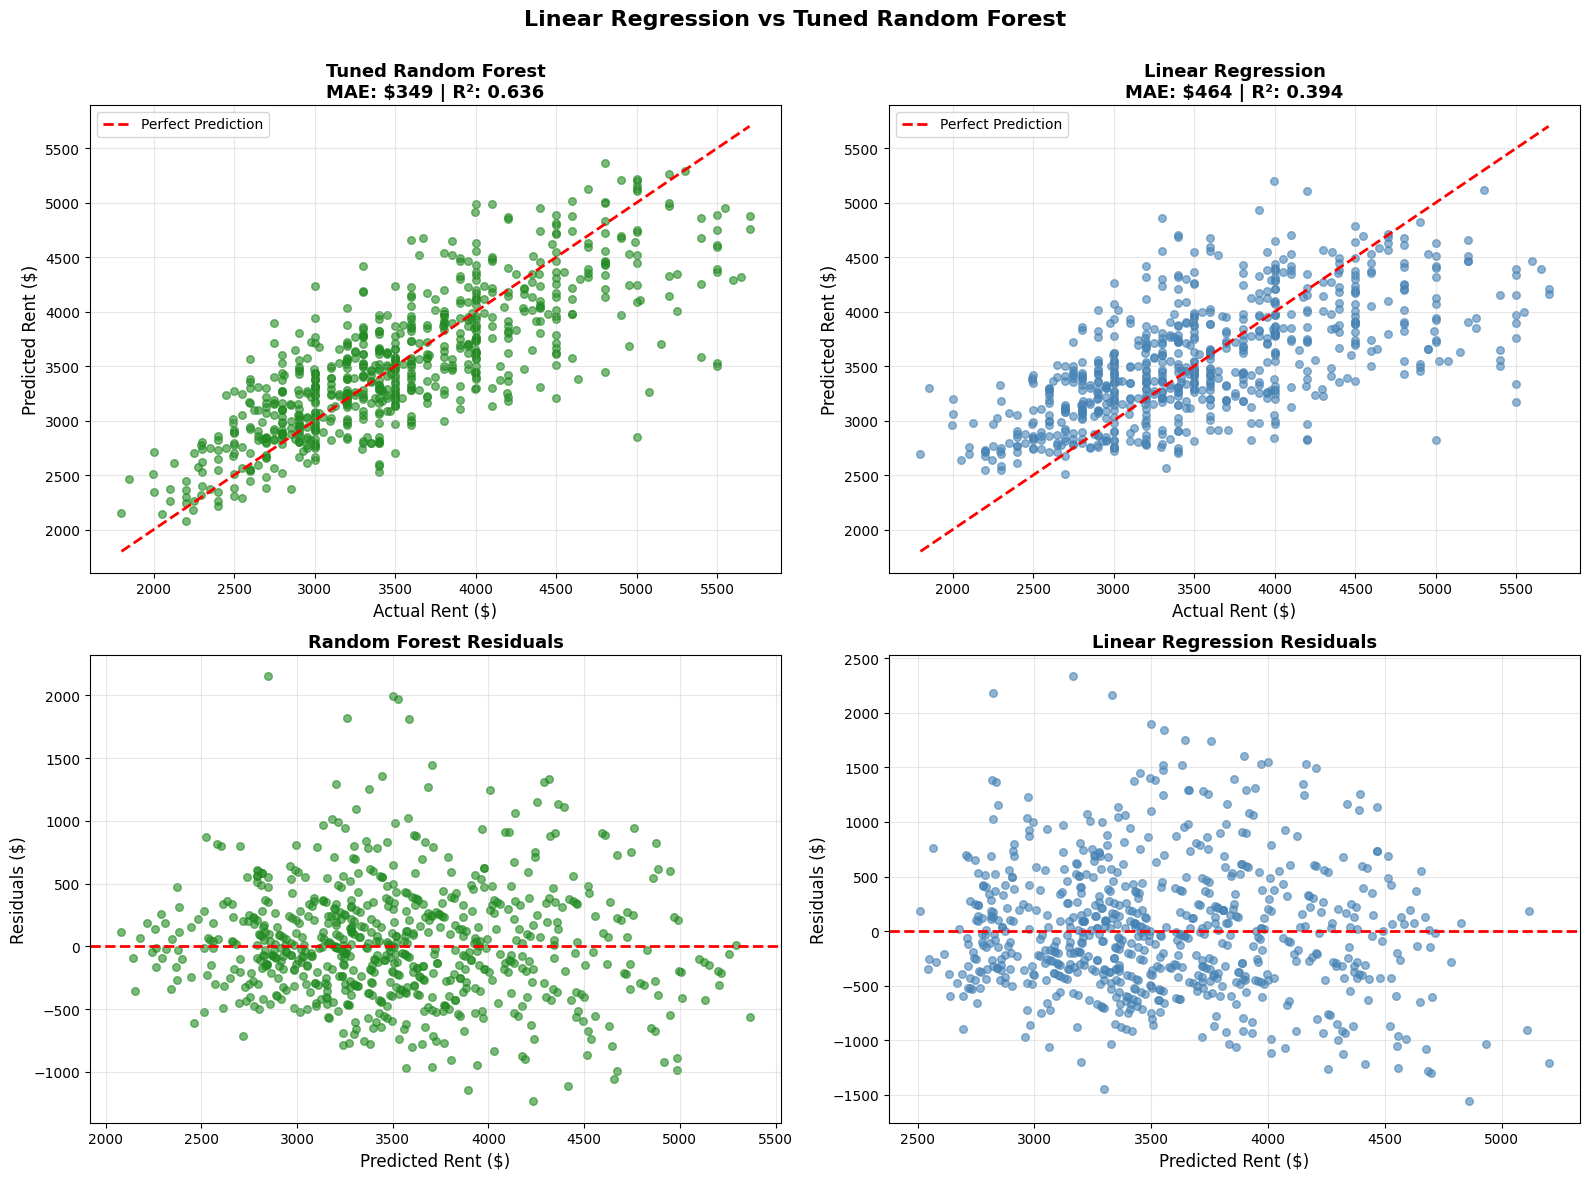

In [124]:
# Set up the visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Linear Regression vs Tuned Random Forest', 
             fontsize=16, fontweight='bold')

# Prepare data for both models
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
y_pred_rf = best_rf.predict(X_test)

# Calculate metrics
lr_mae = mean_absolute_error(y_test, y_pred_lr)
lr_r2 = r2_score(y_test, y_pred_lr)
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)

# 1. Random Forest: Predicted vs Actual
axes[0, 0].scatter(y_test, y_pred_rf, alpha=0.6, color='forestgreen', s=30)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
               'r--', lw=2, label='Perfect Prediction')
axes[0, 0].set_xlabel("Actual Rent ($)", fontsize=12)
axes[0, 0].set_ylabel("Predicted Rent ($)", fontsize=12)
axes[0, 0].set_title(f"Tuned Random Forest\nMAE: ${rf_mae:,.0f} | R²: {rf_r2:.3f}", 
                    fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# 2. Random Forest: Residuals plot
residuals_rf = y_test - y_pred_rf
axes[1, 0].scatter(y_pred_rf, residuals_rf, alpha=0.6, color='forestgreen', s=30)
axes[1, 0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel("Predicted Rent ($)", fontsize=12)
axes[1, 0].set_ylabel("Residuals ($)", fontsize=12)
axes[1, 0].set_title("Random Forest Residuals", 
                    fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 3. Linear Regression: Predicted vs Actual  
axes[0, 1].scatter(y_test, y_pred_lr, alpha=0.6, color='steelblue', s=30)
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
               'r--', lw=2, label='Perfect Prediction')
axes[0, 1].set_xlabel("Actual Rent ($)", fontsize=12)
axes[0, 1].set_ylabel("Predicted Rent ($)", fontsize=12)
axes[0, 1].set_title(f"Linear Regression\nMAE: ${lr_mae:,.0f} | R²: {lr_r2:.3f}", 
                    fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# 4. Linear Regression: Residuals plot
residuals_lr = y_test - y_pred_lr
axes[1, 1].scatter(y_pred_lr, residuals_lr, alpha=0.6, color='steelblue', s=30)
axes[1, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1, 1].set_xlabel("Predicted Rent ($)", fontsize=12)
axes[1, 1].set_ylabel("Residuals ($)", fontsize=12)
axes[1, 1].set_title("Linear Regression Residuals", 
                    fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()

## What Do These Numbers Mean?

The Random Forest is both **more accurate** (lower MAE) and **better at explaining variation** (higher R²) than Linear Regression for Boston rental predictions. You can see it visually—its points hug the red line more closely, especially at the higher rent range, while the Linear Regression struggles to capture those pricier listings.

### 📏 MAE (Mean Absolute Error)  

**What it is:** The average dollar amount our predictions are “off” by.  

**How to read it here:**  
- The **Tuned Random Forest** on the left has an MAE of **$349**, meaning it’s off by about $349 on average.  
- The **Linear Regression** on the right has an MAE of **$464**, so it’s less accurate—its predictions are about $115 further from the real price on average.  

**Real-world meaning:**  
If the rent is $3,000, Random Forest is typically within ±$349, while Linear Regression might miss by closer to ±$464. Lower is better here because it means less “budget shock” when using the model’s predictions.  

### 📊 R² (R-squared / Coefficient of Determination)  

**What it is:** The percentage of variation in rent prices the model can explain.  

**How to read it here:**  
- The Random Forest’s **R² = 0.636** means it explains ~64% of why prices change between listings.  
- The Linear Regression’s **R² = 0.394** means it explains only ~39%—you see this in the chart by the points being more scattered and farther from the red “perfect prediction” line.  

**Real-world meaning:**  
Random Forest captures more of the complex, non-linear patterns in Boston rent prices—things like how location affects high-end properties differently than cheaper ones. The rest (36% for Random Forest, 61% for Linear Regression) comes from factors we didn’t model—like view, amenities, or whether the landlord allows pets.  

### Which Metric Matters More?  
- **MAE** is more tangible for business decisions—“On average, our predictions are off by $349.”  
- **R²** is better for comparing models—Random Forest’s higher R² tells us it’s picking up patterns Linear Regression is missing.  


## That's a Wrap!

In this post, we walked through how to train a machine learning model using real-world structured data collected from Zillow using an Apify scraper. As a result we got a rental price prediction model with an average error of about **$350** and the ability to explain roughly **64%** of price variation. Not bad at all, considering our limited dataset and the fact that we only applied some basic feature engineering.

### How to Improve This Model

If you’re up for a challenge, there’s still plenty of room to make this model stronger. While tuning can only get us so far, the real gains will come from **better data** and **smarter features**.

**1. Gather More Data**  
The more diverse your dataset, the better the model will generalize. Consider pulling listings from other platforms such as [Apartments.com](https://apify.com/epctex/apartments-scraper) or even [Airbnb](https://apify.com/tri_angle/airbnb-scraper), depending on your target use case.

**2. Enrich the Current Data**  
We had to drop over **50%** of our original 10,000 listings because of missing key information. Closing these gaps can dramatically increase your training data. You could:  
- Use geolocation APIs to fill in location-based attributes  
- Leverage the [Zillow Detail Scraper](https://apify.com/maxcopell/zillow-detail-scraper) to extract more information about each property

**3. Double Down on Feature Engineering**  
In this notebook, we added just one new feature. But there’s no real limit to how many relevant features you can create, every meaningful “clue” you give the model can improve its accuracy.  

A strong candidate for a new feature here would be **distance to major points of interest**, like universities, parks, public facilities, or transit hubs. Rent prices often correlate heavily with proximity to these locations, so adding this could almost certainly boost predictive performance.

More complete data and richer features will give your model a bigger boost than endless parameter tweaking ever could. Now you’re all set to explore the 6,000+ ready-made scrapers on the [Apify Store](https://apify.com/store). It's actually pretty amazing that we got this level of accuracy with just a couple thousand listings and a few basic tweaks. A lot of that came down to starting with a well-structured dataset packed with useful data points, which just goes to show the Apify Store is a gold mine for any machine learning project.

I hope you enjoyed building this project as much as I did. That’s all for now—see you in the next tutorial!